# Machine Learning Gender Classifier

We started loading all the required libraries to perform the different functions through the code

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf /content/drive/MyDrive/imdb_crop.tar

Streaming output truncated to the last 5000 lines.
imdb_crop/98/nm0232998_rm2180228352_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2200475648_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2232200192_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2267584512_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2331093504_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2384117504_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2465311232_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2534190080_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2549197312_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2563156736_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2579933952_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2683415040_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2688802304_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2739898368_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2756675584_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm276465664_1968-5-11_2007.jpg
imdb_crop/98/nm0232998_rm2837228288_1968-5-11_2007.jpg
imdb_crop/98/nm

In [ ]:
print("TensorFlow version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


TensorFlow version: 2.15.0
GPU is available


In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## DATA PREPROCESSING

The information of each picture is in a .mat file, so we charge that file into a variable we can read

In [ ]:
#Load MATLAB file 'imdb.mat' using the scipy.io module.
mat = scipy.io.loadmat('/content/imdb_crop/imdb.mat')

In [ ]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'imdb'])

Then we convert the data into a pandas dataframe for easier handling and analysis

In [ ]:
# Extract the data from the 'imdb' key in the provided data
imdb_data = mat['imdb'][0][0][0]

# Get the number of instances in the data
instances = imdb_data.shape[1]

# Define the column names for the dataframe
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create an empty dataframe with the specified columns and number of instances
df = pd.DataFrame(index=range(instances), columns=columns)

# Extract the data from "imdb" key in the loaded data
current_record = mat["imdb"][0][0]

# Assign the values from the current_array to the corresponding columns in the dataframe
for j, column in enumerate(columns[:len(current_record)]):
    df[column] = pd.DataFrame(current_record[j][0])



Here we convert MATLAB datenum values in the 'dob' column of the DataFrame 'df' to exact dates and calculate the corresponding years for 'date_of_birth,' followed by calculating the age by subtracting 'date_of_birth' from the 'photo_taken' column.

We define the Male gender as 1 and Female as 0.

In [ ]:
from datetime import datetime, timedelta

def datenum_to_year(datenum):
    epoch = datetime(1, 1, 1)  # Define the epoch as January 1, 0001
    ordinal = int(datenum) + 366  # Adjust for MATLAB datenum offset
    exact_date = datetime.fromordinal(ordinal) + timedelta(days=datenum % 1)  # Add fractional days
    return exact_date.year

# 1.  Convert MATLAB datenum values to years and assign the result to the 'date_of_birth' column
df['date_of_birth'] = df['dob'].apply(datenum_to_year)

# 2.  Calculate the age by subtracting 'date_of_birth' from the 'photo_taken' column
df['age'] = df['photo_taken'] - df['date_of_birth']

# 3.  Removing pictures that don't have faces based on the 'face_score' column
df = df.loc[df['face_score'] != -np.inf]

# 4.  Removing pictures with more than one face based on the 'second_face_score'
df = df.loc[df['second_face_score'].isna()]

# 5.  Removing pictures with age greater than 100 or less than or equal to 0
df = df.loc[df['age'] <= 60]
df = df.loc[df['age'] > 0]

# 6.  Droping rows with missing values in the 'gender' column
df.dropna(subset=['gender'], inplace=True)

# Displaying the value counts of the 'gender' column using value_counts() to understand the distribution of genders in the dataset.
gender_counts = df['gender'].value_counts()
display(gender_counts)

# 7.  Filtering the DataFrame df based on a 'face_score' threshold of 2, removing rows with lower-quality face images.
df = df[df['face_score'] >= 2]

# 8. Converting each element in the 'full_path' column to a string by using str() and np.squeeze() within a list comprehension,
# the code assigns the resulting string representations to a new 'path' column in the DataFrame.
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
display(df)

gender
1.0    93636
0.0    79551
Name: count, dtype: int64

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg
14,702986,1974,[02/nm0000002_rm238734336_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[2135.2177839424635, 765.8537799794512, 3499....",4.865421,NaN,1926,48,02/nm0000002_rm238734336_1924-9-16_1974.jpg
47,706650,1963,[03/nm0000003_rm1883436032_1934-9-28_1963.jpg],0.0,[Brigitte Bardot],"[[4.054, 652.694, 1167.552, 1816.192]]",3.056358,NaN,1936,27,03/nm0000003_rm1883436032_1934-9-28_1963.jpg
50,706650,1963,[03/nm0000003_rm2034430976_1934-9-28_1963.jpg],0.0,[Brigitte Bardot],"[[1045.2505006892818, 350.00950022976065, 1564...",3.776049,NaN,1936,27,03/nm0000003_rm2034430976_1934-9-28_1963.jpg
52,706650,1963,[03/nm0000003_rm2067985408_1934-9-28_1963.jpg],0.0,[Brigitte Bardot],"[[142.6052732576393, 142.6052732576393, 560.92...",2.723419,NaN,1936,27,03/nm0000003_rm2067985408_1934-9-28_1963.jpg
...,...,...,...,...,...,...,...,...,...,...,...
460715,726831,2011,[08/nm3994408_rm73386752_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[161, 161, 448, 448]]",4.801987,NaN,1991,20,08/nm3994408_rm73386752_1989-12-29_2011.jpg
460716,726831,2011,[08/nm3994408_rm744468480_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[300.756, 96.276, 422.592, 218.112]]",2.370091,NaN,1991,20,08/nm3994408_rm744468480_1989-12-29_2011.jpg
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,1991,20,08/nm3994408_rm761245696_1989-12-29_2011.jpg
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,1991,20,08/nm3994408_rm943369728_1989-12-29_2011.jpg


In [ ]:
df.describe()

,dob,photo_taken,gender,face_score,second_face_score,date_of_birth,age
count,128645.000000,128645.000000,128645.000000,128645.000000,0.0,128645.00000,128645.000000
mean,720020.926324,2005.978553,0.508710,3.705801,NaN,1972.85376,33.124793
std,4788.664666,8.170157,0.499926,1.038556,NaN,13.11444,10.942963
min,693794.000000,1961.000000,0.000000,2.000001,NaN,1901.00000,1.000000
25%,717347.000000,2004.000000,0.000000,2.832820,NaN,1966.00000,25.000000
50%,720450.000000,2008.000000,1.000000,3.639147,NaN,1974.00000,32.000000
75%,723368.000000,2011.000000,1.000000,4.507998,NaN,1982.00000,40.000000
max,733601.000000,2015.000000,1.000000,7.381689,NaN,2010.00000,60.000000


Then we print the regeneral information of our dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128645 entries, 12 to 460722
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dob                128645 non-null  int32  
 1   photo_taken        128645 non-null  uint16 
 2   full_path          128645 non-null  object 
 3   gender             128645 non-null  float64
 4   name               128645 non-null  object 
 5   face_location      128645 non-null  object 
 6   face_score         128645 non-null  float64
 7   second_face_score  0 non-null       float64
 8   date_of_birth      128645 non-null  int64  
 9   age                128645 non-null  int64  
 10  path               128645 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(4), uint16(1)
memory usage: 10.6+ MB


This code converts the gender values in the DataFrame 'df' to integers, facilitating the further exploratory data analysis, and then prints the data types of the DataFrame columns.

In [ ]:
# Convert the gender values to integers before grouping
df['gender'] = df['gender'].astype(int)
print(df.dtypes)

dob                    int32
photo_taken           uint16
full_path             object
gender                 int64
name                  object
face_location         object
face_score           float64
second_face_score    float64
date_of_birth          int64
age                    int64
path                  object
target                object
dtype: object


Here we grouped the DataFrame 'df' by 'age' and 'gender' columns and counts the occurrences of each combination. Then we created a stacked bar chart visualizing the joint distribution of age and gender using custom colors for each gender category. The x-axis represents age, the y-axis represents count, and the legend distinguishes between male and female categories. The resulting plot provides insights into the distribution of ages across gender categories.

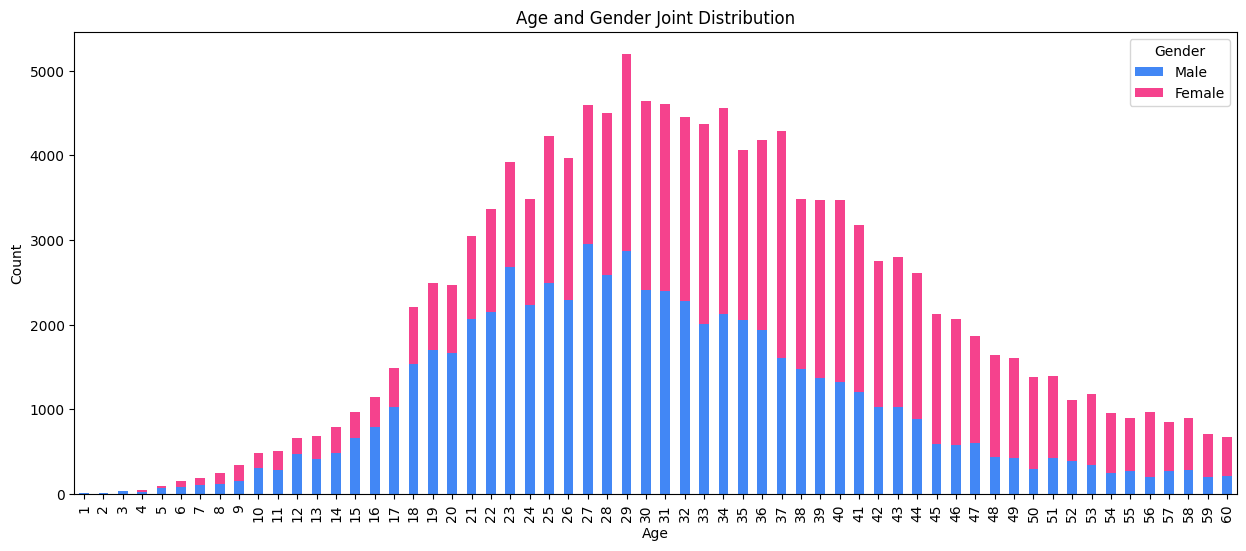

In [ ]:

# Grouping the DataFrame 'df' by 'age' and 'gender' columns and counting the occurrences of each combination
age_groups = df.groupby(['age', 'gender']).size().unstack()

# Define custom colors for each gender category
colors = {0: '#4287f5', 1: '#f5428d'}

# Plotting the grouped data as a stacked bar chart with custom colors
age_groups.plot(kind='bar', stacked=True, figsize=(15, 6), color=[colors[col] for col in age_groups.columns])

# Adding a label to the x-axis
plt.xlabel('Age')

# Adding a label to the y-axis
plt.ylabel('Count')

# Adding a title to the plot
plt.title('Age and Gender Joint Distribution')

# Adding a legend to the plot with the title 'Gender'
plt.legend(title='Gender', labels=['Male', 'Female'])

# Displaying the plot
plt.show()

This code generates a pie chart to display the gender distribution in the dataset. It calculates gender counts, assigns colors, and creates the chart with percentage labels and a title for clarity.

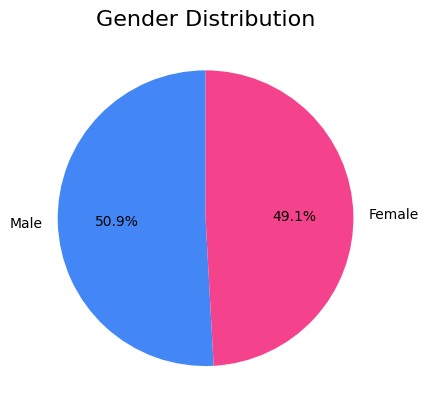

In [ ]:
# Define the labels for the genders
gender_labels = ['Male', 'Female']

# Calculate the count of each gender category
gender_counts = df['gender'].value_counts()

# Define custom colors for the pie slices
colors = ['#4287f5', '#f5428d']

# Create a pie chart
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', colors=colors, startangle=90)

# Add a title and adjust the font size
plt.title('Gender Distribution', fontsize=16)

# Display the chart
plt.show()

The data type of the output variable is changed to match the requirements of the data generators.

In [ ]:
df['gender'] = df['gender'].astype(str)

We shuffle the data set before split into training and testing.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the DataFrame.
total, reserve = train_test_split(df, test_size=0.5, random_state=42)

# Splitting the shuffled DataFrame
train, temp = train_test_split(total, test_size=0.3, random_state=42)

# Splitting the 'temp' DataFrame into 'val' and 'test' DataFrames, with approximately 50% for validation and 50% for testing.
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Printing the number of rows and columns in the 'train', 'val', and 'test' DataFrames, respectively.
print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)


Train shape: (45025, 12)
Validation shape: (9648, 12)
Test shape: (9649, 12)


In [ ]:
df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path,target
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg,2
14,702986,1974,[02/nm0000002_rm238734336_1924-9-16_1974.jpg],0,[Lauren Bacall],"[[2135.2177839424635, 765.8537799794512, 3499....",4.865421,NaN,1926,48,02/nm0000002_rm238734336_1924-9-16_1974.jpg,2
47,706650,1963,[03/nm0000003_rm1883436032_1934-9-28_1963.jpg],0,[Brigitte Bardot],"[[4.054, 652.694, 1167.552, 1816.192]]",3.056358,NaN,1936,27,03/nm0000003_rm1883436032_1934-9-28_1963.jpg,1
50,706650,1963,[03/nm0000003_rm2034430976_1934-9-28_1963.jpg],0,[Brigitte Bardot],"[[1045.2505006892818, 350.00950022976065, 1564...",3.776049,NaN,1936,27,03/nm0000003_rm2034430976_1934-9-28_1963.jpg,1
52,706650,1963,[03/nm0000003_rm2067985408_1934-9-28_1963.jpg],0,[Brigitte Bardot],"[[142.6052732576393, 142.6052732576393, 560.92...",2.723419,NaN,1936,27,03/nm0000003_rm2067985408_1934-9-28_1963.jpg,1
...,...,...,...,...,...,...,...,...,...,...,...,...
460715,726831,2011,[08/nm3994408_rm73386752_1989-12-29_2011.jpg],0,[Jane Levy],"[[161, 161, 448, 448]]",4.801987,NaN,1991,20,08/nm3994408_rm73386752_1989-12-29_2011.jpg,1
460716,726831,2011,[08/nm3994408_rm744468480_1989-12-29_2011.jpg],0,[Jane Levy],"[[300.756, 96.276, 422.592, 218.112]]",2.370091,NaN,1991,20,08/nm3994408_rm744468480_1989-12-29_2011.jpg,1
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,1991,20,08/nm3994408_rm761245696_1989-12-29_2011.jpg,1
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,1991,20,08/nm3994408_rm943369728_1989-12-29_2011.jpg,1


The next cell performs a comparison of image quality by varying the number of pixels. The goal of this comparison is to determine the ideal size for the images before they are fed into the models.

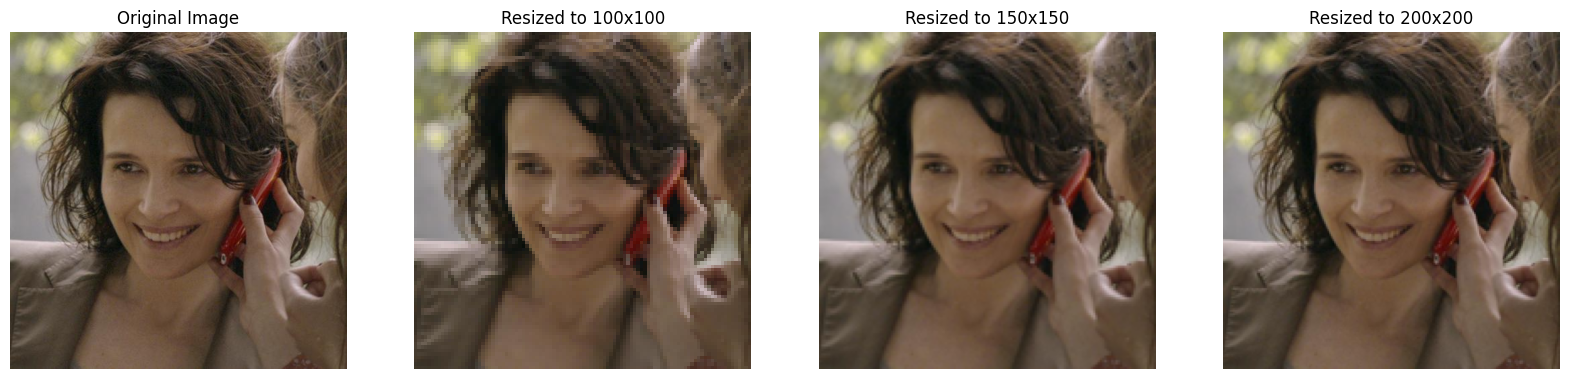

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/imdb_crop/00/nm0000300_rm50772992_1964-3-9_2011.jpg"

# Load the original image
original_image = Image.open(image_path)

# Resize the image to different sizes
sizes = [(100, 100), (150, 150), (200, 200)]
resized_images = [original_image.resize(size) for size in sizes]

# Plot the images
fig, axes = plt.subplots(1, len(sizes) + 1, figsize=(20, 5))

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Plot the resized images
for i, (size, image) in enumerate(zip(sizes, resized_images), start=1):
    axes[i].imshow(image)
    axes[i].set_title(f"Resized to {size[0]}x{size[1]}")
    axes[i].axis("off")

plt.show()

We implemented image data generators using TensorFlow Keras to augment the training data. These generators include techniques like pixel rescaling, rotation, brightness adjustment, zooming, and horizontal flipping. We also set up generators for validation data. The training and test datasets are loaded from dataframes, resized to 150x150 pixels, and converted to grayscale.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an image data generator for the training data with pixel value rescaling, rotation, brightness adjustment, zooming, and horizontal flipping.
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True
)

# Creating an image data generator for the validation and test data with pixel value rescaling only.
val_test_datagen = ImageDataGenerator(rescale=1./255.)

# Create augmented train, validation, and test datasets
train_aug_dataset = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/imdb_crop/",
    x_col='path',
    y_col='gender',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42
)

# Create validation and test datasets
val_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    directory="/content/imdb_crop/",
    x_col='path',
    y_col='gender',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

test_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="/content/imdb_crop/",
    x_col='path',
    y_col='gender',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)


Found 45025 validated image filenames belonging to 2 classes.
Found 9648 validated image filenames belonging to 2 classes.
Found 9649 validated image filenames belonging to 2 classes.


## MODEL TRAINING

### Convolutional Neural Network




The architecture of this model consists on a sequence of convolutional layers, each with an equal or greater number of filters than its predecessor.
To counter the risk of overfitting, we have incorporated two techniques: Dropout, which randomly deactivates neurons in each training iteration to promote generalization, and Ridge regularization, a way of penalizing model coefficients. These measures are particularly crucial as they prevent the excessive capture of noisy patterns during the initial stages of the model, ensuring that the learned patterns are more meaningful and generalizable in the process.
The network ends with fully connected Dense layers leading to an output layer with 1 node, which produces an output of 0 for women and 1 for men. The model is compiled with binary cross-entropy loss and the Adam optimizer.

In [ ]:
# Defining the architecture of the convolutional neural network.

# Input layer
input_layer = Input(shape=(150, 150, 1))


x = Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=254, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)


# Output layer with 1 node.
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
cnn1 = Model(inputs=input_layer, outputs=output_layer)

# Compiling the model
cnn1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
cnn1.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 batch_normalization_50 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 70, 70, 64)        102464    
                                                                 
 batch_normalization_51 (Ba  (None, 70, 70, 64)        256

We employed some callback functions to optimize our CNN model training for gender estimation. These include EarlyStopping and LearningRateScheduler, to adjust the learning rate via step decay. The model was trained with augmented data and these callbacks to enhance convergence.

In [ ]:
# Define the step decay function for the learning rate
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 4
    lrate = initial_lrate * (drop ** (epoch // epochs_drop))
    return lrate

# Use the GPU for training
with tf.device('/GPU:0'):
    # Define your callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(step_decay)

    # Train the model with class weights
    cnn1_history = cnn1.fit(
        train_aug_dataset,
        validation_data=test_dataset,
        epochs=200,
        callbacks=[early_stopping, lr_scheduler]
    )

Epoch 1/200
704/704 [==============================] - 141s 195ms/step - loss: 0.9417 - accuracy: 0.8342 - val_loss: 0.7109 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 2/200
704/704 [==============================] - 137s 194ms/step - loss: 0.5042 - accuracy: 0.8988 - val_loss: 0.5003 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 3/200
704/704 [==============================] - 137s 194ms/step - loss: 0.3968 - accuracy: 0.9056 - val_loss: 0.4257 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 4/200
704/704 [==============================] - 139s 198ms/step - loss: 0.3732 - accuracy: 0.9060 - val_loss: 0.5207 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/200
704/704 [==============================] - 139s 197ms/step - loss: 0.3234 - accuracy: 0.9170 - val_loss: 0.3380 - val_accuracy: 0.9053 - lr: 5.0000e-04
Epoch 6/200
704/704 [==============================] - 139s 197ms/step - loss: 0.3085 - accuracy: 0.9181 - val_loss: 0.3061 - val_accuracy: 0.9178 - lr: 5.0000e-04
Epoch 7/200
704/704 [===========

We generated line charts to visualize the loss and accuracy trends of our CNN model during training. These charts illustrate the evolution of train and test loss as well as train and test accuracy over the epochs. The two subplots, divided into loss and accuracy, provide insights into model performance. The chart was saved as a PNG image for further reference or sharing.

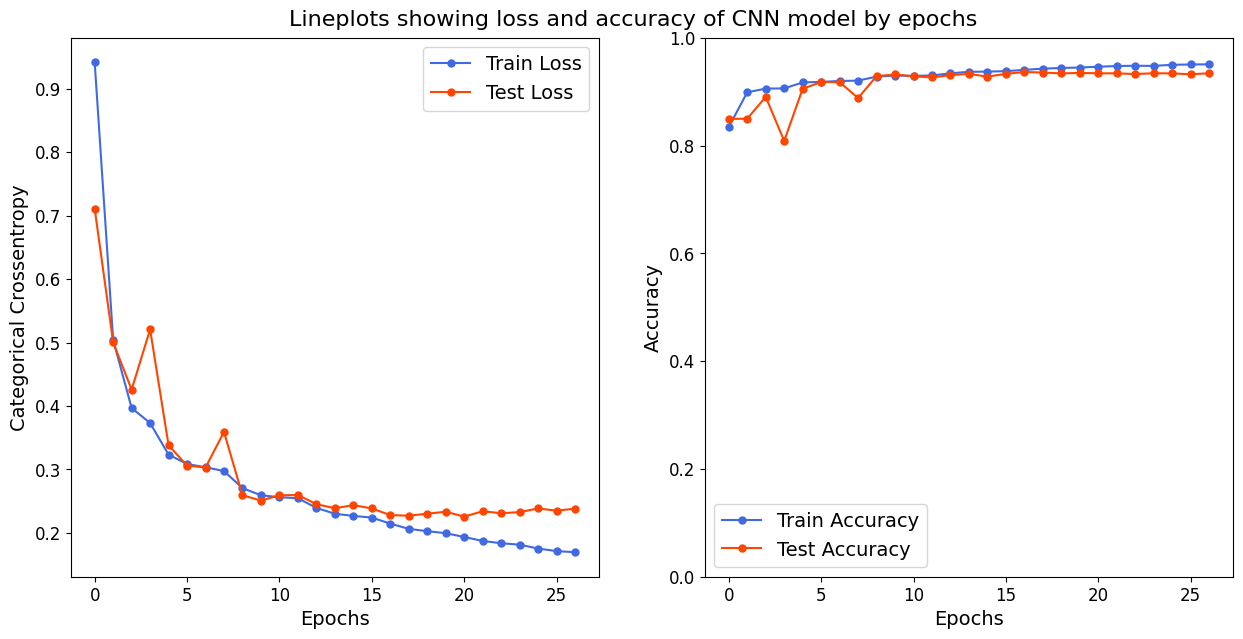

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = cnn1_history.history['loss']
test_loss = cnn1_history.history['val_loss']
train_accuracy = cnn1_history.history['accuracy']
test_accuracy = cnn1_history.history['val_accuracy']



# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylim(0, 1)


fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


# Exporting plot image in PNG format.
plt.savefig('/content/drive/MyDrive/DL/final_cnn_loss_accuracy.png', bbox_inches='tight')

We saved the trained CNN model as an h5 file for further use.

In [ ]:
# Saving the model as a keras file for possible use later.
cnn1.save(f"/content/drive/MyDrive/DL/gender_model.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We evaluated the CNN model on the test dataset, saved the model in a different format (pickle file), generated predictions, and created and visualized a confusion matrix and classification reports to assess classification performance.

151/151 [==============================] - 11s 75ms/step


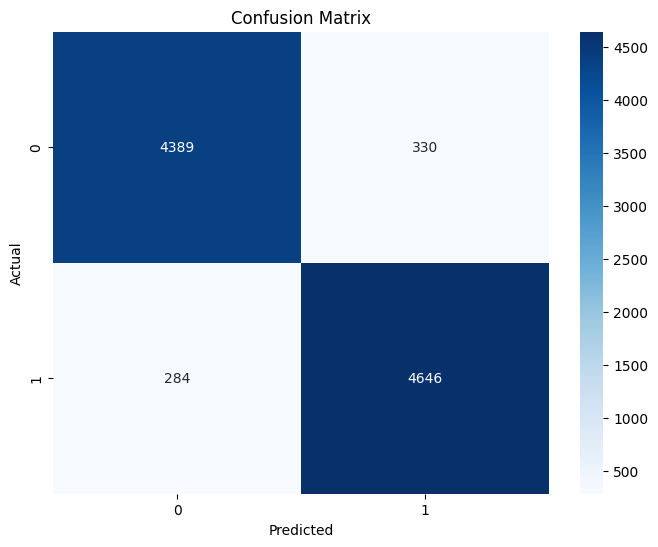

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the predictions for the test dataset
y_pred = cnn1.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get the true labels for the test dataset
y_true = test_dataset.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig(f'/content/drive/MyDrive/DL/cnn_conf_mat.png', bbox_inches='tight')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/DL/model.pkl'

# Save the model
with open(model_path, 'wb') as file:
    pickle.dump(cnn1, file)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the training, test, and validation datasets
test_pred = cnn1.predict(test_dataset)
val_pred = cnn1.predict(val_dataset)

# Convert predictions to binary values (0 or 1)
test_pred_binary = (test_pred > 0.5).astype(int)
val_pred_binary = (val_pred > 0.5).astype(int)

# Create classification reports
test_classification_report = classification_report(test_dataset.classes, test_pred_binary)
val_classification_report = classification_report(val_dataset.classes, val_pred_binary)

# Print confusion matrices and classification reports
print("\nTest Classification Report:\n", test_classification_report)
print("\nValidation Classification Report:\n", val_classification_report)


151/151 [==============================] - 11s 71ms/step

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      4719
           1       0.93      0.94      0.94      4930

    accuracy                           0.94      9649
   macro avg       0.94      0.94      0.94      9649
weighted avg       0.94      0.94      0.94      9649


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      4756
           1       0.93      0.94      0.93      4892

    accuracy                           0.93      9648
   macro avg       0.93      0.93      0.93      9648
weighted avg       0.93      0.93      0.93      9648



### Logistic Regression

In [ ]:
# Initialize empty arrays to store augmented data and labels
X_train = []
y_train = []

# Concatenate augmented data and labels from all batches
for _ in range(len(train_aug_dataset)):
    X_batch, y_batch = next(train_aug_dataset)
    X_train.append(X_batch)
    y_train.append(y_batch)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Reshape the data if needed (e.g., for grayscale images)
X_train = X_train.reshape(X_train.shape[0], -1)

In [ ]:
# Initialize empty arrays to store augmented data and labels
X_test = []
y_test = []

# Concatenate augmented data and labels from all batches
for _ in range(len(test_dataset)):
    X_batch, y_batch = next(test_dataset)
    X_test.append(X_batch)
    y_test.append(y_batch)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Reshape the data if needed (e.g., for grayscale images)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Scale the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model with a higher max_iter
logistic_model = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

# Train the logistic regression model with scaled data
logistic_model.fit(X_train_scaled, np.argmax(y_train, axis=1))


c:\Users\HP G8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [ ]:
# Evaluate the model
predictions = logistic_model.predict(X_test_scaled)
print(predictions)

[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.metrics import classification_report

# Get true labels for both training and test datasets
train_true_labels = np.argmax(y_train, axis=1)
test_true_labels = np.argmax(y_test, axis=1)

# Get classification reports for both datasets
train_report = classification_report(train_true_labels, train_predictions, target_names=["Female", "Male"])
test_report = classification_report(test_true_labels, predictions, target_names=["Female", "Male"])

# Print classification reports
print("Classification Report for Training Dataset:")
print(train_report)
print()
print("Classification Report for Test Dataset:")
print(test_report)

Classification Report for Training Dataset:
              precision    recall  f1-score   support

      Female       0.80      0.80      0.80     22157
        Male       0.81      0.81      0.81     22868

    accuracy                           0.80     45025
   macro avg       0.80      0.80      0.80     45025
weighted avg       0.80      0.80      0.80     45025


Classification Report for Test Dataset:
              precision    recall  f1-score   support

      Female       0.55      0.56      0.56      4719
        Male       0.57      0.56      0.57      4930

    accuracy                           0.56      9649
   macro avg       0.56      0.56      0.56      9649
weighted avg       0.56      0.56      0.56      9649



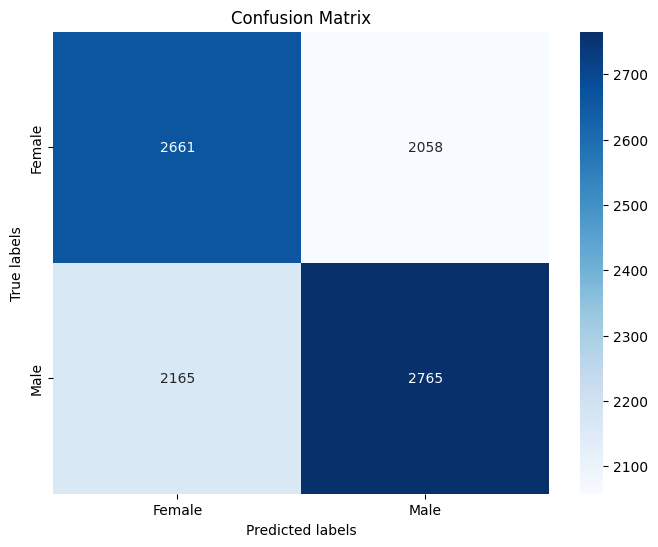

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


**Insights:**

The model clearly is overfitting to the training data, as the performance on the test data is notably lower. Overfitting occurs when the model learns the training data too well, including noise or random fluctuations, which may not generalize well to new, unseen data.

The performance metrics are slightly lower for the Female class compared to the Male class. This could indicate a class imbalance issue where there are fewer instances of the Female class, leading to lower performance metrics for that class.

The model lacks generalization ability, meaning it does not capture the underlying patterns in the data well enough to perform adequately on unseen data. This could be due to various reasons such as insufficient training data, inappropriate model complexity, or inadequate feature representation.

In [ ]:
import pickle

# Define the file path where you want to save the model
model_file_path = 'logistic_regression_model.pkl'

# Save the model to a pickle file
with open(model_file_path, 'wb') as file:
    pickle.dump(logistic_model, file)

print("Model saved successfully as", model_file_path)

Model saved successfully as logistic_regression_model.pkl


## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 2: Train Decision Tree Classifier
# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(max_depth=5)

# Train the Decision Tree Classifier
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
# Predict on the training set
train_predictions = dt_classifier.predict(X_train)

# Predict on the testing set
test_predictions = dt_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for training dataset
train_predictions = dt_classifier.predict(X_train)
train_report = classification_report(y_train, train_predictions)
print("Classification Report for Training Dataset:")
print(train_report)

# Generate classification report for testing dataset
test_report = classification_report(y_test, predictions_rf)
print("\nClassification Report for Testing Dataset:")
print(test_report)

Classification Report for Training Dataset:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62     22157
           1       0.64      0.68      0.66     22868

   micro avg       0.64      0.64      0.64     45025
   macro avg       0.64      0.64      0.64     45025
weighted avg       0.64      0.64      0.64     45025
 samples avg       0.64      0.64      0.64     45025


Classification Report for Testing Dataset:
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      4719
           1       0.49      0.42      0.45      4930

   micro avg       0.48      0.48      0.48      9649
   macro avg       0.48      0.48      0.48      9649
weighted avg       0.48      0.48      0.48      9649
 samples avg       0.48      0.48      0.48      9649



In [ ]:
# Predict on the training set
train_predictions = dt_classifier.predict(X_train)

# Predict on the testing set
test_predictions = dt_classifier.predict(X_test)

print(test_predictions)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


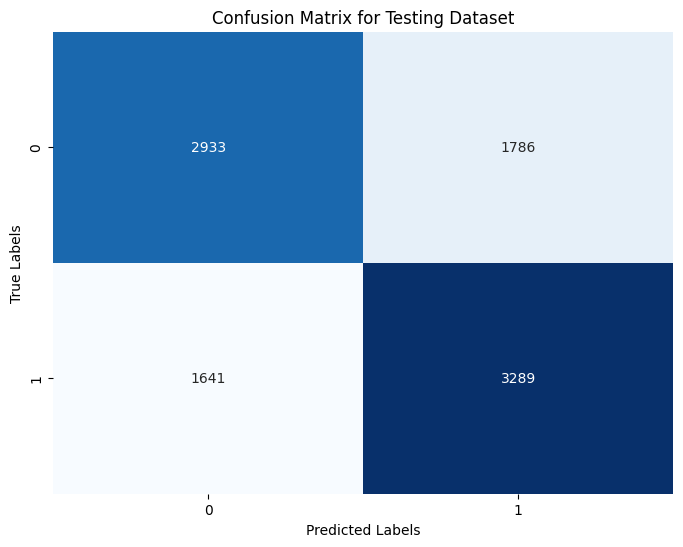

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np  # Import numpy

test_predictions_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix for testing dataset
test_cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions_labels)

# Plot confusion matrix for testing dataset
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Testing Dataset")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [ ]:
# Save the trained model to a file
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_classifier, file)

**Insights:**
The model perform better on the training dataset compared to the testing dataset, as indicated by higher precision, recall, and F1-score values for the training dataset.

There is a noticeable drop in performance when moving from the training to the testing dataset, which is clearly overfitting. This means that the model has learned to fit the training data too closely and may not generalize well to unseen data.

Further tuning of the model or exploring other algorithms may be necessary to improve performance on the testing dataset and reduce overfitting.

## Comparison of 3 Models

- The CNN model outperforms both Logistic Regression and Decision Tree Classifier in terms of precision, recall, F1-score, and accuracy on both the test and validation datasets. This suggests that the CNN model is better at capturing complex patterns in the data.
- Logistic Regression and Decision Tree Classifier show similar performance, with Logistic Regression having slightly better precision, recall, and F1-score on the test dataset.
- Decision Tree Classifier shows signs of overfitting, as indicated by the significant drop in performance on the test dataset compared to the training dataset.
- Overall, the CNN model appears to be the most promising for gender classification based on the provided results. It achieves high accuracy and balanced performance metrics on both training and test datasets.